### Unidad II. Regresiones y reducción de dimensionalidad.

## Análisis de Regresión Logística.

- Curvas ROC.

In [15]:
using RDatasets
survey = dataset("MASS", "survey")
head(survey)

,Sex,WrHnd,NWHnd,WHnd,Fold,Pulse,Clap,Exer,Smoke,Height,MI,Age
1,Female,18.5,18.0,Right,R on L,92,Left,Some,Never,173.0,Metric,18.25
2,Male,19.5,20.5,Left,R on L,104,Left,None,Regul,177.8,Imperial,17.583
3,Male,18.0,13.3,Right,L on R,87,Neither,None,Occas,NaN,NA,16.917
4,Male,18.8,18.9,Right,R on L,NA,Neither,None,Never,160.0,Metric,20.333
5,Male,20.0,20.0,Right,Neither,35,Right,Some,Never,165.0,Metric,23.667
6,Female,18.0,17.7,Right,L on R,64,Right,Some,Never,172.72,Imperial,21.0


### [Regresión Logística](https://en.wikipedia.org/wiki/Logistic_regression)

In [3]:
using GLM

In [17]:
survey[:Male] = survey[:Sex] .== "Male"

237-element DataArrays.PooledDataArray{Bool,UInt8,1}:
 false
  true
  true
  true
  true
 false
  true
 false
  true
  true
 false
  true
 false
     ⋮
 false
 false
  true
 false
  true
 false
  true
 false
 false
 false
  true
 false

In [21]:
variables = [:Male,:Pulse,:Height,:Age]

4-element Array{Symbol,1}:
 :Male  
 :Pulse 
 :Height
 :Age   

In [25]:
subset = survey[:,variables]
head(subset)

,Male,Pulse,Height,Age
1,false,92,173.0,18.25
2,true,104,177.8,17.583
3,true,87,NA,16.917
4,true,NA,160.0,20.333
5,true,35,165.0,23.667
6,false,64,172.72,21.0


In [26]:
for var in variables
    subset[isnan(subset[var]), var] = NA
end

In [27]:
head(subset)

,Male,Pulse,Height,Age
1,false,92,173.0,18.25
2,true,104,177.8,17.583
3,true,87,NA,16.917
4,true,NA,160.0,20.333
5,true,35,165.0,23.667
6,false,64,172.72,21.0


In [29]:
nrow(subset)

170

In [30]:
complete_cases!(subset)
head(subset)

,Male,Pulse,Height,Age
1,false,92,173.0,18.25
2,true,104,177.8,17.583
3,true,35,165.0,23.667
4,false,64,172.72,21.0
5,true,83,182.88,18.833
6,false,74,157.0,35.833


In [31]:
nrow(subset)

170

In [32]:
glm(Male ~ Pulse + Height + Age, subset, Binomial(), LogitLink())

DataFrames.DataFrameRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Distributions.Binomial,GLM.LogitLink},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Float64}

Formula: Male ~ 1 + Pulse + Height + Age

Coefficients:
                Estimate Std.Error   z value Pr(>|z|)
(Intercept)     -45.7242   7.00602  -6.52642   <1e-10
Pulse        -0.00382921 0.0182807 -0.209467   0.8341
Height          0.261851 0.0389575   6.72145   <1e-10
Age            0.0468799 0.0397444   1.17954   0.2382


In [34]:
using RCall 

R"""
logistica = glm(Male ~ Pulse + Height + Age, $subset, family = binomial(link = "logit"))
"""

RCall.RObject{RCall.VecSxp}

Call:  glm(formula = Male ~ Pulse + Height + Age, family = binomial(link = "logit"), 
    data = `#JL`$subset)

Coefficients:
(Intercept)        Pulse       Height          Age  
 -45.724244    -0.003829     0.261851     0.046880  

Degrees of Freedom: 169 Total (i.e. Null);  166 Residual
Null Deviance:	    235.7 
Residual Deviance: 129.7 	AIC: 137.7


In [35]:
R"summary(logistica)"

RCall.RObject{RCall.VecSxp}

Call:
glm(formula = Male ~ Pulse + Height + Age, family = binomial(link = "logit"), 
    data = `#JL`$subset)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.08226  -0.64980  -0.02893   0.50849   3.04301  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -45.724244   7.006024  -6.526 6.74e-11 ***
Pulse        -0.003829   0.018281  -0.209    0.834    
Height        0.261851   0.038958   6.721 1.80e-11 ***
Age           0.046880   0.039744   1.180    0.238    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 235.67  on 169  degrees of freedom
Residual deviance: 129.68  on 166  degrees of freedom
AIC: 137.68

Number of Fisher Scoring iterations: 5



### [Stepwise regression](https://en.wikipedia.org/wiki/Stepwise_regression)

In [39]:
R"""
logistica = step(glm(Male ~ Pulse + Height + Age, $subset, family = binomial(link = "logit")))
"""

Start:  AIC=137.68
Male ~ Pulse + Height + Age

         Df Deviance    AIC
- Pulse   1   129.72 135.72
- Age     1   131.40 137.40
<none>        129.68 137.68
- Height  1   234.35 240.35

Step:  AIC=135.73
Male ~ Height + Age

         Df Deviance    AIC
- Age     1   131.57 135.57
<none>        129.72 135.72
- Height  1   234.98 238.98

Step:  AIC=135.57
Male ~ Height

         Df Deviance    AIC
<none>        131.57 135.57
- Height  1   235.67 237.67


RCall.RObject{RCall.VecSxp}

Call:  glm(formula = Male ~ Height, family = binomial(link = "logit"), 
    data = `#JL`$subset)

Coefficients:
(Intercept)       Height  
   -44.4492       0.2584  

Degrees of Freedom: 169 Total (i.e. Null);  168 Residual
Null Deviance:	    235.7 
Residual Deviance: 131.6 	AIC: 135.6


### [ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)

In [40]:
# Pkg.clone("https://github.com/JuliaML/MLPlots.jl.git")
using ROCAnalysis
using MLPlots

In [45]:
objetivo    = convert(Vector{Float64}, subset[  subset[:Male], :Height ] )
no_objetivo = convert(Vector{Float64}, subset[ !subset[:Male], :Height ] )

85-element Array{Float64,1}:
 173.0 
 172.72
 157.0 
 156.2 
 155.0 
 157.0 
 166.4 
 154.94
 176.5 
 180.34
 168.0 
 165.0 
 157.48
   ⋮   
 153.5 
 160.0 
 163.0 
 168.9 
 167.64
 162.56
 170.18
 167.0 
 169.0 
 165.1 
 160.0 
 168.5 

In [47]:
R = roc(objetivo, no_objetivo)

ROCAnalysis.Roc{Float64}([1.0,0.964706,0.952941,0.847059,0.811765,0.635294,0.541176,0.482353,0.423529,0.376471  …  0.0823529,0.0470588,0.0352941,0.0352941,0.0235294,0.0235294,0.0117647,0.0117647,0.0,0.0],[0.0,0.0,0.0117647,0.0117647,0.0235294,0.0235294,0.0705882,0.0705882,0.0941176,0.105882  …  0.258824,0.282353,0.317647,0.329412,0.341176,0.388235,0.4,0.552941,0.611765,1.0],Bool[true,true,false,false,false,true,false,false,false,false  …  false,true,false,false,true,false,true,false,true,true],[152.0,154.94,155.0,160.0,160.02,165.0,165.1,167.0,167.64,168.0  …  174.0,175.0,175.26,176.0,176.5,177.0,178.0,178.5,180.34,182.0],[-Inf,-2.63906,-2.63906,-2.63906,-2.63906,-1.28785,-1.28785,-1.28785,-1.28785,-1.28785  …  0.223144,0.223144,0.916291,0.916291,0.916291,1.60944,1.60944,2.89037,2.89037,Inf])


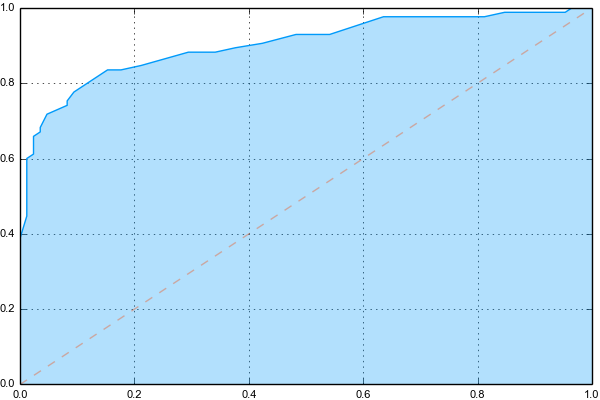

In [49]:
plot(R)

In [50]:
1- auc(R)

0.9029757785467128